In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET
import re

log_file = "results.xml"
tree = ET.parse(log_file)
root = tree.getroot()

rows = []

# Regular expression to extract the type inside DenseMatrix<...>
dm_pattern = re.compile(r"DenseMatrix<([^>]+)>")
# Regular expression to extract the CSV file name from a top-level section name
csv_pattern = re.compile(r"\s*(.+)")

def process_section(section, csv_file=None, parent_name=""):
    current_name = section.attrib.get("name", "")
    # At the top-level, try to extract the CSV file name.
    if csv_file is None and not parent_name:
        m = csv_pattern.match(current_name)
        if m:
            csv_file = m.group(1).strip()
            composite_name = ""  # reset composite name for inner sections
        else:
            # If no CSV file label, use current name as composite name.
            composite_name = current_name
    else:
        composite_name = current_name if not parent_name else f"{parent_name} > {current_name}"

    results = []
    child_sections = section.findall("Section")
    if child_sections:
        for child in child_sections:
            results.extend(process_section(child, csv_file=csv_file, parent_name=composite_name))
    else:
        overall_results = section.find("OverallResults")
        duration = overall_results.attrib.get("durationInSeconds", "") if overall_results is not None else ""
        failures = overall_results.attrib.get("failures", "") if overall_results is not None else ""
        results.append((csv_file, composite_name, duration, failures))
    return results

# Iterate over each TestCase element in the XML
for testcase in root.findall(".//TestCase"):
    test_case_name = testcase.attrib.get("name", "")
    # Extract DenseMatrix string type
    m = dm_pattern.search(test_case_name)
    string_type = m.group(1) if m else None

    # If there are nested Section elements, process them.
    testcase_sections = testcase.findall("Section")
    if testcase_sections:
        for sec in testcase_sections:
            # Process each top-level section; if it has a CSV file name, it will be extracted.
            section_tuples = process_section(sec)
            for csv_file, inner_section, duration, failures in section_tuples:
                rows.append({
                    "CSVFile": csv_file,
                    "section": inner_section,
                    "durationinseconds": duration,
                    "failures": failures,
                    "testcase": test_case_name,
                    "Stringtype": string_type
                })
    else:
        # If no sections are present, look for an OverallResult directly under the TestCase.
        overall_result = testcase.find("OverallResult")
        duration = overall_result.attrib.get("durationInSeconds", "") if overall_result is not None else ""
        failures = overall_result.attrib.get("failures", "") if overall_result is not None else ""
        rows.append({
            "CSVFile": None,
            "section": None,
            "durationinseconds": duration,
            "failures": failures,
            "testcase": test_case_name,
            "Stringtype": string_type
        })

# Create the DataFrame and drop rows without a valid Stringtype.
df = pd.DataFrame(rows).dropna(subset=["Stringtype"])

# Optionally extract an alternative from the test case name if needed.
df['alternative'] = df['testcase'].str.extract(r'-\s*(EwBinaryMat|EwBinarySca)\)', expand=False)
df['CSVFile'] = df['CSVFile'].str.split('/').str[-1]
# Define a regex pattern with named capture groups for each parameter
pattern = (
    r"dataset_rows_(?P<rows>\d+)_"
    r"cols_(?P<cols>\d+)_"
    r"mean_(?P<mean>\d+)_"
    r"std_(?P<std>\d+)_"
    r"dup_(?P<dup>\d+)_"
    r"dist_(?P<dist>\w+)_"
    r"seed_(?P<seed>\d+)_"
    r"min_(?P<min>\d+)_"
    r"max_(?P<max>\d+)\.csv"
    r"_numRowsRead_(?P<numRowsRead>\d+)"
)

# Extract the parameters into a new DataFrame
params = df['CSVFile'].str.extract(pattern)

# Join the extracted parameters back to the original DataFrame
df = df.join(params)
# Define your custom ordering for the string type.
order = ["std::string", "FixedStr16", "FixedStr32", "FixedStr64",
         "FixedStr128", "FixedStr256", "Umbra_t", "NewUmbra_t",
         "UnorderedDictionaryEncodedString", "OrderedDictionaryEncodedString"]

df["Stringtype"] = pd.Categorical(df["Stringtype"], categories=order, ordered=True)
print(df['dist'].unique()[2])


pd.set_option('display.max_rows', 100)
df_sorted = df.sort_values(by=["CSVFile", "section", "alternative", "Stringtype"])
df_sorted[df_sorted["failures"]=="0"]

nan


,CSVFile,section,durationinseconds,failures,testcase,Stringtype,alternative,rows,cols,mean,std,dup,dist,seed,min,max,numRowsRead
995,FillLongString,,0.004613,0,StringsExperiments (Fill) - DenseMatrix<std::s...,std::string,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,FillLongString,,0.121576,0,StringsExperiments (Fill) - DenseMatrix<std::s...,std::string,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1011,FillLongString,,0.004976,0,StringsExperiments (Fill) - DenseMatrix<FixedS...,FixedStr128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1013,FillLongString,,0.102668,0,StringsExperiments (Fill) - DenseMatrix<FixedS...,FixedStr128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1015,FillLongString,,0.008914,0,StringsExperiments (Fill) - DenseMatrix<FixedS...,FixedStr256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,dataset_rows_1000000_cols_5_mean_5_std_3_dup_5...,readCsv(),0.202444,0,StringsExperiments (ReadCsv) - DenseMatrix<Fix...,FixedStr256,NaN,1000000,5,5,3,50,uniform,3,1,10,1000000
87,dataset_rows_1000000_cols_5_mean_5_std_3_dup_5...,readCsv(),0.101776,0,StringsExperiments (ReadCsv) - DenseMatrix<Umb...,Umbra_t,NaN,1000000,5,5,3,50,uniform,3,1,10,1000000
97,dataset_rows_1000000_cols_5_mean_5_std_3_dup_5...,readCsv(),0.095803,0,StringsExperiments (ReadCsv) - DenseMatrix<New...,NewUmbra_t,NaN,1000000,5,5,3,50,uniform,3,1,10,1000000
107,dataset_rows_1000000_cols_5_mean_5_std_3_dup_5...,readCsv(),0.666888,0,StringsExperiments (ReadCsv) - DenseMatrix<Uno...,UnorderedDictionaryEncodedString,NaN,1000000,5,5,3,50,uniform,3,1,10,1000000


<ipython-input-60-847b298c4b3f>:31: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  new_df['Stringtype'] = new_df['Stringtype'].replace(rename_map)


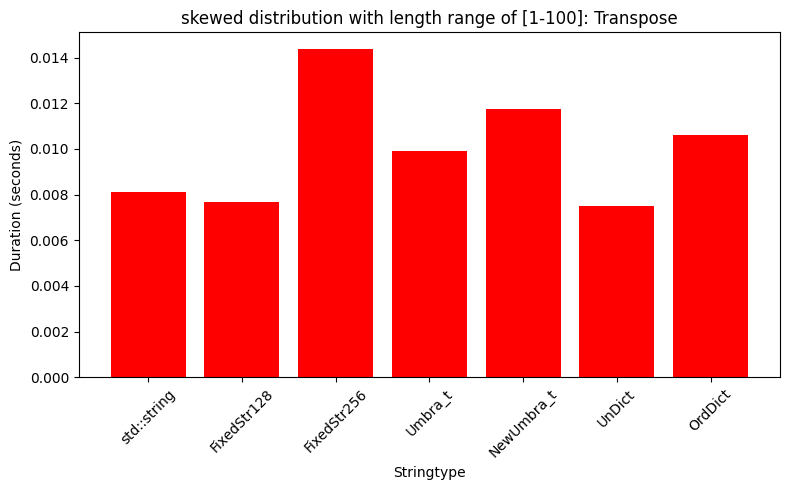

<ipython-input-60-847b298c4b3f>:31: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  new_df['Stringtype'] = new_df['Stringtype'].replace(rename_map)


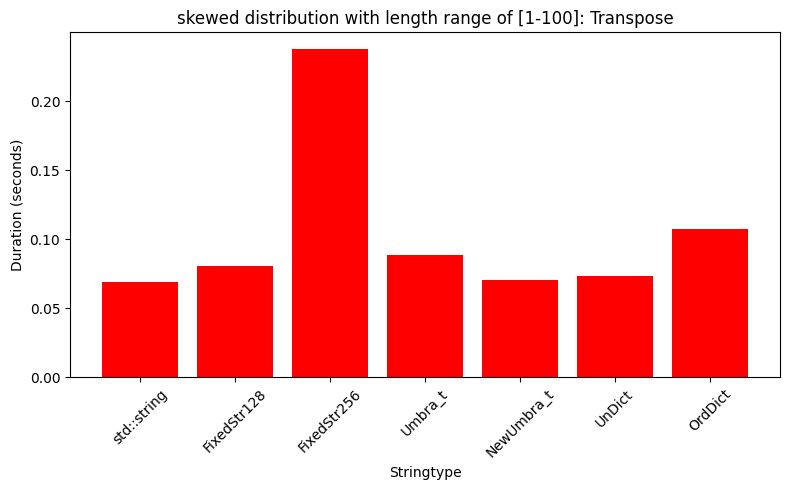

<ipython-input-60-847b298c4b3f>:31: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  new_df['Stringtype'] = new_df['Stringtype'].replace(rename_map)


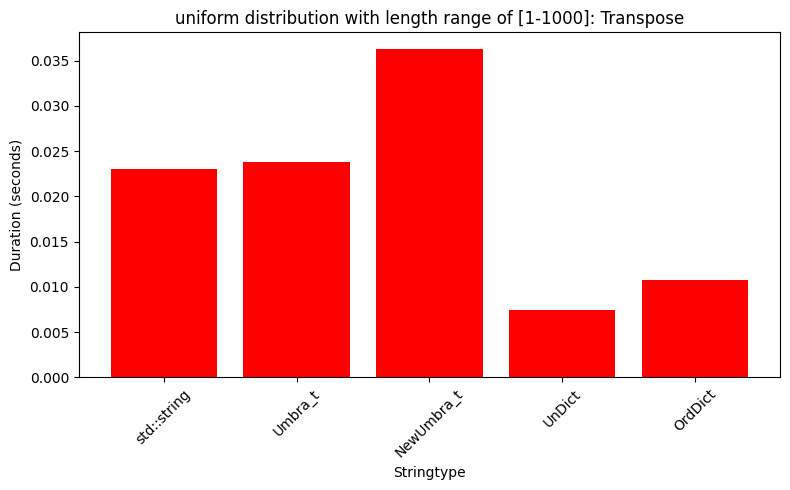

<ipython-input-60-847b298c4b3f>:31: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  new_df['Stringtype'] = new_df['Stringtype'].replace(rename_map)


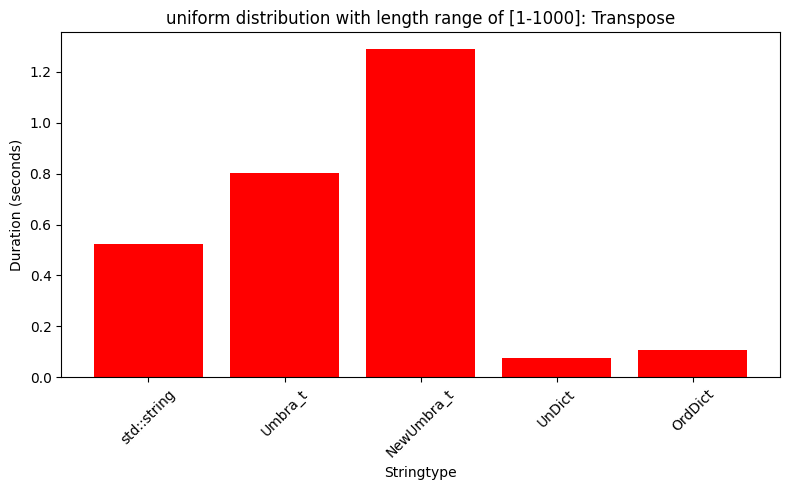

<ipython-input-60-847b298c4b3f>:31: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  new_df['Stringtype'] = new_df['Stringtype'].replace(rename_map)


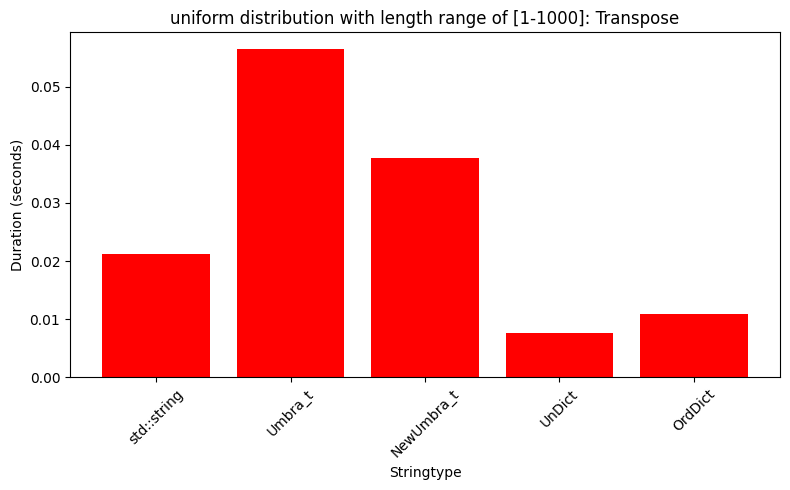

<ipython-input-60-847b298c4b3f>:31: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  new_df['Stringtype'] = new_df['Stringtype'].replace(rename_map)


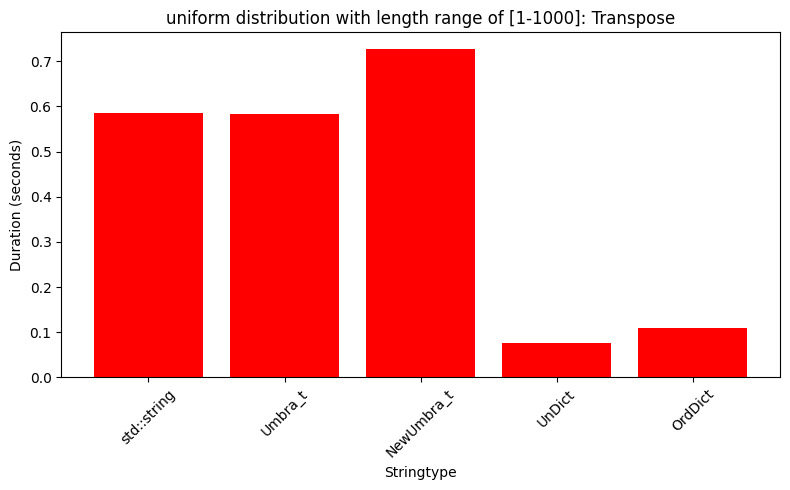

<ipython-input-60-847b298c4b3f>:31: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  new_df['Stringtype'] = new_df['Stringtype'].replace(rename_map)


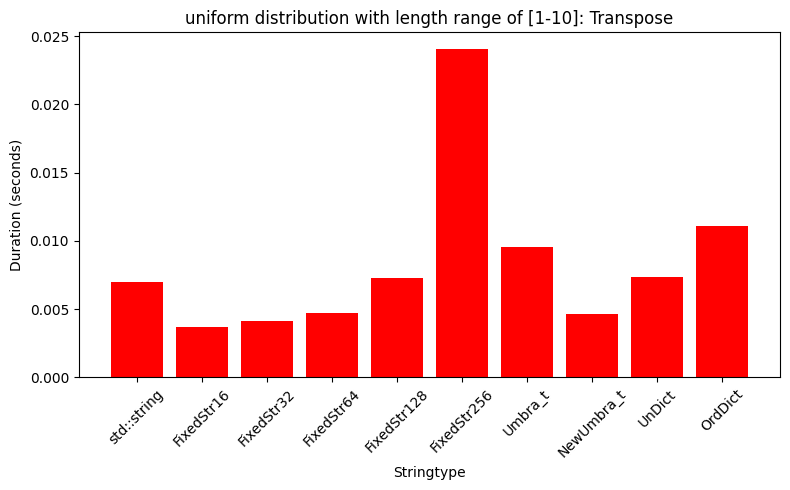

<ipython-input-60-847b298c4b3f>:31: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  new_df['Stringtype'] = new_df['Stringtype'].replace(rename_map)


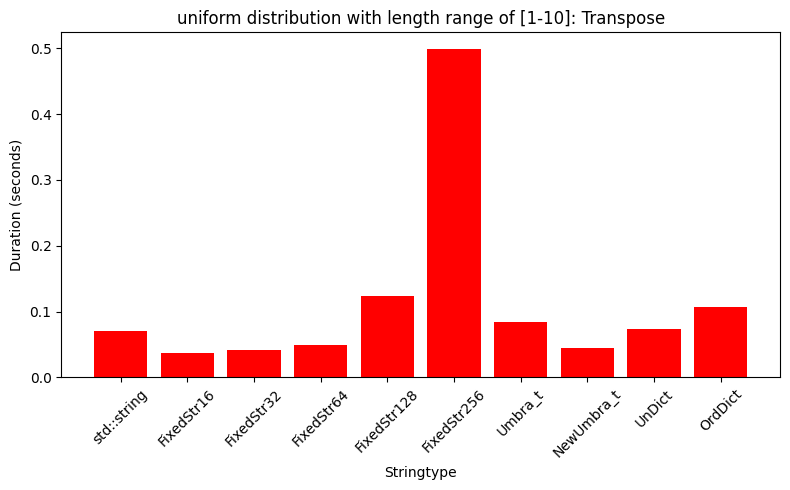

<ipython-input-60-847b298c4b3f>:31: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  new_df['Stringtype'] = new_df['Stringtype'].replace(rename_map)


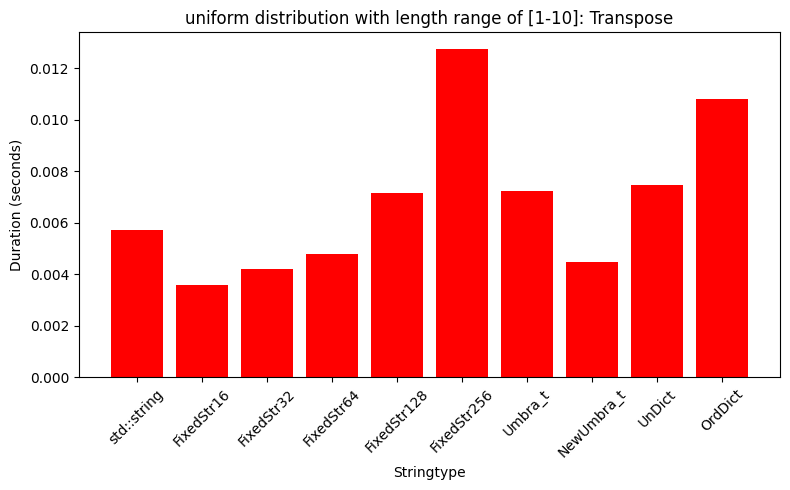

<ipython-input-60-847b298c4b3f>:31: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  new_df['Stringtype'] = new_df['Stringtype'].replace(rename_map)


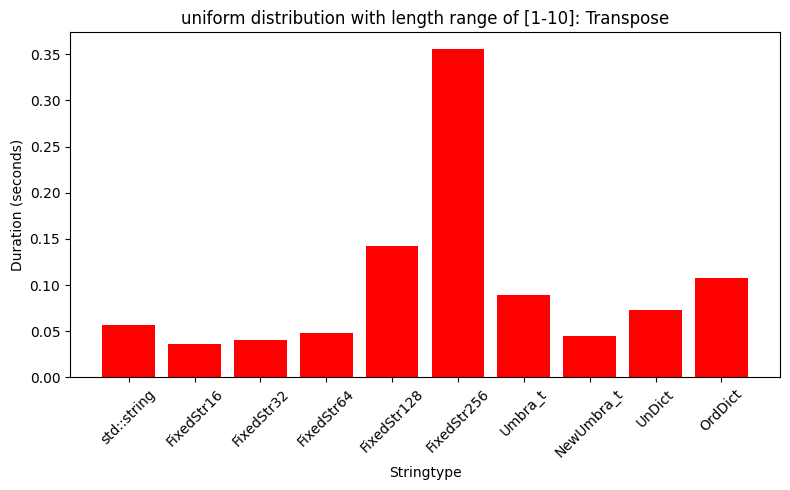

In [ ]:
import matplotlib.pyplot as plt

# Parameters
operation = 'EQ' # 'EQ', 'NEQ', 'LT', 'GT', 'Concat', 'Lower', 'Upper', 'readCsv()', 'Transpose', 'Reverse', 'Reshape'
dist = 'skewed' # Not used
rowsRead = '1000000'


dfs = dict(tuple(df.groupby('CSVFile')))
for csv_file, group_df in dfs.items():
    dfs[csv_file] = group_df.sort_values('section')


def plot_section_bars(df):
    csv_filename = df['CSVFile'].iloc[0]

    fixed_order = ["std::string", "FixedStr16", "FixedStr32", "FixedStr64",
                   "FixedStr128", "FixedStr256", "Umbra_t", "NewUmbra_t",
                   "UnDict", "OrdDict"]

    rename_map = {
        "UnorderedDictionaryEncodedString": "UnDict",
        "OrderedDictionaryEncodedString": "OrdDict"
    }

    for section, group in df.groupby('section'):
        if section == operation:
            new_df = group[['Stringtype', 'durationinseconds']].copy()
            new_df['durationinseconds'] = pd.to_numeric(new_df['durationinseconds'], errors='coerce')

            new_df['Stringtype'] = new_df['Stringtype'].replace(rename_map)

            new_df = (new_df
                      .set_index('Stringtype')
                      .reindex(fixed_order)
                      .dropna(subset=['durationinseconds'])
                      .reset_index()
                     )
            #new_df = new_df[(~new_df['Stringtype'].isin(['UnDict', 'OrdDict']))]

            if new_df.empty:
                continue

            fig, ax = plt.subplots(figsize=(8, 5))
            ax.bar(new_df['Stringtype'], new_df['durationinseconds'], color='red')

            distribution = group['dist'].iloc[0]
            min_val = group['min'].iloc[0]
            max_val = group['max'].iloc[0]

            ax.set_title(f"{distribution} distribution with length range of [{min_val}-{max_val}]: {section}")
            ax.set_xlabel("Stringtype")
            ax.set_ylabel("Duration (seconds)")

            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()


dfs.keys()

for frame in dfs:
    plot_section_bars(dfs[frame])


<ipython-input-59-8085b616702a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fill['durationinseconds'] = pd.to_numeric(df_fill['durationinseconds'], errors='coerce')
<ipython-input-59-8085b616702a>:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_fill['Stringtype'] = df_fill['Stringtype'].replace(rename_map)
<ipython-input-59-8085b616702a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

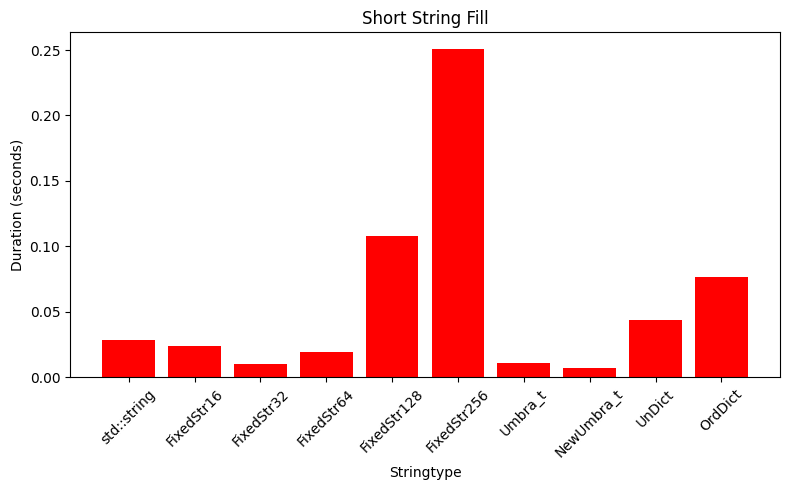

In [ ]:
import matplotlib.pyplot as plt
df_fill = df[df['CSVFile'] == 'FillShortString']
df_fill['durationinseconds'] = pd.to_numeric(df_fill['durationinseconds'], errors='coerce')
rename_map = {
    "UnorderedDictionaryEncodedString": "UnDict",
    "OrderedDictionaryEncodedString": "OrdDict"
}
df_fill['Stringtype'] = df_fill['Stringtype'].replace(rename_map)

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(df_fill['Stringtype'], df_fill['durationinseconds'], color='red')

ax.set_title(f"Short String Fill")
ax.set_xlabel("Stringtype")
ax.set_ylabel("Duration (seconds)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-58-4ff659c60ee8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fill['durationinseconds'] = pd.to_numeric(df_fill['durationinseconds'], errors='coerce')
<ipython-input-58-4ff659c60ee8>:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_fill['Stringtype'] = df_fill['Stringtype'].replace(rename_map)
<ipython-input-58-4ff659c60ee8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

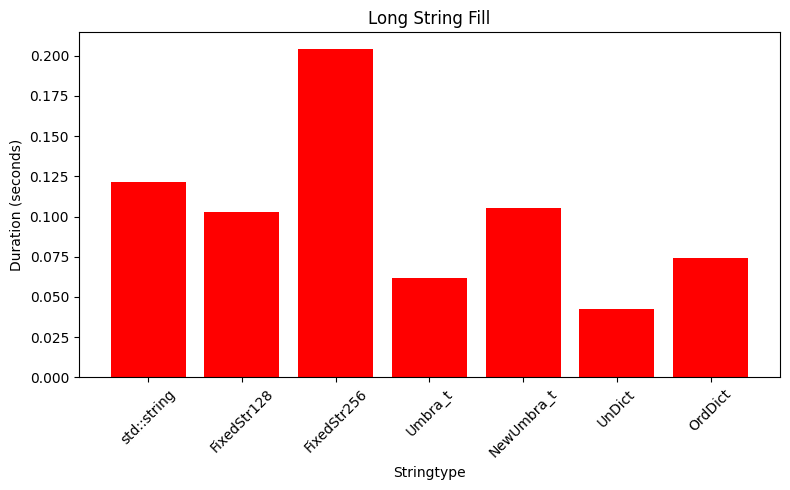

In [ ]:
import matplotlib.pyplot as plt
df_fill = df[(df['CSVFile'] == 'FillLongString') & (~df['Stringtype'].isin(['FixedStr16', 'FixedStr32', 'FixedStr64']))]
df_fill['durationinseconds'] = pd.to_numeric(df_fill['durationinseconds'], errors='coerce')
rename_map = {
    "UnorderedDictionaryEncodedString": "UnDict",
    "OrderedDictionaryEncodedString": "OrdDict"
}
df_fill['Stringtype'] = df_fill['Stringtype'].replace(rename_map)


fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(df_fill['Stringtype'], df_fill['durationinseconds'], color='red')

ax.set_title(f"Long String Fill")
ax.set_xlabel("Stringtype")
ax.set_ylabel("Duration (seconds)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()